In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

import time
import copy

import numpy as np

import chainer
import chainer.functions as F
import chainer.links as L

from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl

from tqdm import tqdm_notebook as tqdm

init_notebook_mode()

In [2]:
#import data from kaggle dataset called "huge stock market"

try:
    data = pd.read_csv('../input/Data/Stocks/goog.us.txt')
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.set_index('Date')

except (FileNotFoundError):

    import datetime
    import pandas_datareader as pdr
    from pandas import Series, DataFrame

    start = datetime.datetime(2010, 1, 1)
    end = datetime.datetime(2017, 1, 11)

    data = pdr.get_data_yahoo("AAPL", start, end)

print(data.index.min(), data.index.max())

split_index = int(len(data)/2)
date_split = data.index[split_index]
train = data[:split_index]
test = data[split_index:]

#date_split = '2016-01-01'
#train = data[:date_split]
#test = data[date_split:]

print(len(data), len(train), len(test))

display(data)




2014-03-27 00:00:00 2017-11-10 00:00:00
916 458 458


Open      High       Low    Close   Volume  OpenInt
Date                                                              
2014-03-27   568.00   568.000   552.920   558.46    13052        0
2014-03-28   561.20   566.430   558.670   559.99    41003        0
2014-03-31   566.89   567.000   556.930   556.97    10772        0
2014-04-01   558.71   568.450   558.710   567.16     7932        0
2014-04-02   599.99   604.830   562.190   567.00   146697        0
2014-04-03   569.85   587.280   564.130   569.74  5087500        0
2014-04-04   574.65   577.770   543.000   543.14  6377600        0
2014-04-07   540.74   548.480   527.150   538.15  4368717        0
2014-04-08   543.07   555.000   541.610   554.90  3148563        0
2014-04-09   559.77   565.370   552.950   564.14  3323579        0
2014-04-10   564.99   565.000   539.900   540.95  4027113        0
2014-04-11   532.50   540.000   526.530   530.60  3915647        0
2014-04-14   537.74   544.100   529.560   532.52  2565391        0
2014-04-15   536.82   538.450   518.460   536.44  3846267        0
2014-04-16   543.00   557.000   540.000   556.54  4869745        0
2014-04-17   548.81   549.500   531.150   536.10  6792593        0
2014-04-21   536.10   536.700   525.600   528.62  2559924        0
2014-04-22   528.64   537.230   527.510   534.81  2358993        0
2014-04-23   533.79   533.870   526.250   526.94  2049887        0
2014-04-24   529.97   531.650   522.120   525.16  1879376        0
2014-04-25   522.51   524.700   515.420   516.18  2096997        0
2014-04-28   517.55   518.600   502.800   517.15  3325565        0
2014-04-29   516.91   529.460   516.320   527.70  2691849        0
2014-04-30   527.60   528.000   522.520   526.66  1746405        0
2014-05-01   527.15   532.930   523.880   531.35  1900411        0
2014-05-02   533.76   534.000   525.610   527.93  1684811        0
2014-05-05   524.73   528.900   521.320   527.81  1021301        0
2014-05-06   525.23   526.810   515.060   515.14  1647435        0
2014-05-07   515.79   516.680   503.300   509.96  3215781        0
2014-05-08   508.41   517.230   506.450   511.00  2015769        0
...             ...       ...       ...      ...      ...      ...
2017-10-02   959.98   962.540   947.840   953.27  1282861        0
2017-10-03   954.00   958.000   949.140   957.79   888306        0
2017-10-04   957.00   960.390   950.690   951.68   951792        0
2017-10-05   955.49   970.910   955.180   969.96  1213368        0
2017-10-06   966.70   979.460   963.360   978.38  1172738        0
2017-10-09   980.00   985.425   976.110   977.00   890722        0
2017-10-10   980.00   981.570   966.080   972.60   968115        0
2017-10-11   973.72   990.710   972.250   989.25  1692880        0
2017-10-12   987.45   994.120   985.000   987.91  1278363        0
2017-10-13   992.00   997.210   989.000   989.68  1169587        0
2017-10-16   992.10   993.907   984.000   992.00   910246        0
2017-10-17   990.29   996.440   988.590   992.18  1290157        0
2017-10-18   991.77   996.720   986.975   992.81  1057506        0
2017-10-19   986.00   988.880   978.390   984.45  1312902        0
2017-10-20   989.44   991.000   984.580   988.20  1176177        0
2017-10-23   989.52   989.520   966.120   968.45  1478308        0
2017-10-24   970.00   972.230   961.000   970.54  1206099        0
2017-10-25   968.37   976.090   960.520   973.33  1210419        0
2017-10-26   980.00   987.600   972.200   972.56  2031039        0
2017-10-27  1009.11  1048.390  1008.250  1019.27  5165933        0
2017-10-30  1014.00  1024.970  1007.500  1017.11  2085062        0
2017-10-31  1015.22  1024.000  1010.420  1016.64  1331391        0
2017-11-01  1017.21  1029.670  1016.950  1025.50  1373444        0
2017-11-02  1021.76  1028.090  1013.010  1025.58  1048970        0
2017-11-03  1022.11  1032.650  1020.310  1032.48  1076350        0
2017-11-06  1028.99  1034.870  1025.000  1025.90  1124765        0
2017-11-07  1027.27  1033.960  1027.120  1033.33  1112146     

In [3]:
def plot_train_test(train, test, date_split):
    
    data = [
        Candlestick(x=train.index, open=train['Open'], high=train['High'], low=train['Low'], close=train['Close'], name='train'),
        Candlestick(x=test.index, open=test['Open'], high=test['High'], low=test['Low'], close=test['Close'], name='test')
    ]
    layout = {
         'shapes': [
             {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
         ],
        'annotations': [
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}
        ]
    }
    figure = Figure(data=data, layout=layout)
    iplot(figure)
    

In [4]:
plot_train_test(train, test, date_split)

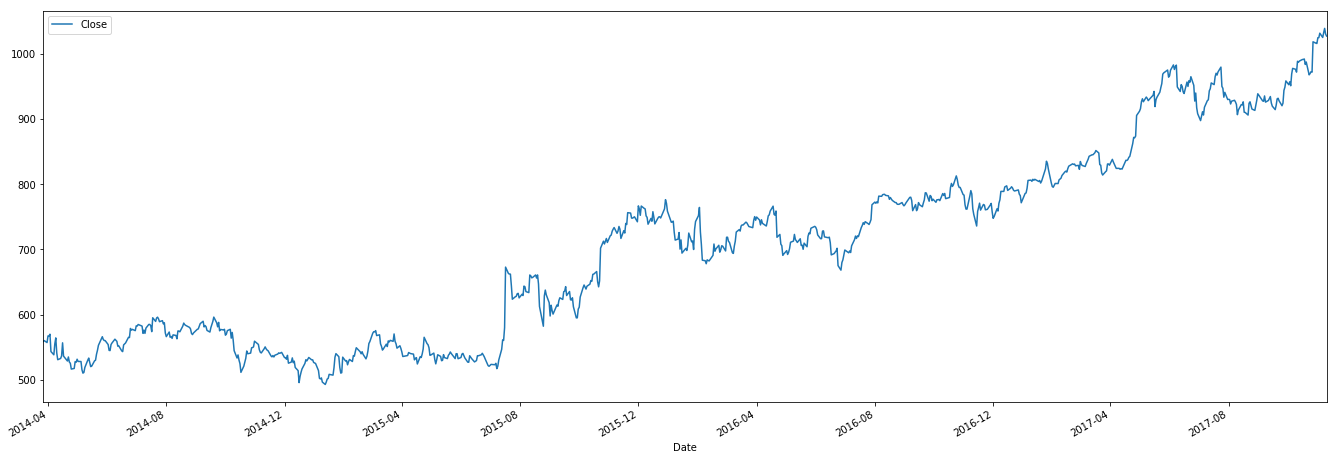

In [5]:
import matplotlib.pyplot as plt

data['Close'].plot(figsize=(23,8))

plt.legend()
plt.show()


In [6]:
class Environment:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0
        
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        
        return [self.position_value] + self.history, reward, self.done, self.profits # obs, reward, done, profits

In [7]:
env = Environment(train)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    print(env.step(pact))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
([1.5299999999999727, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.5299999999999727], 0, False, 0)
([-1.4900000000000091, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.5299999999999727, -3.0199999999999818], 0, False, 0)
([18.889999999999873, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [8]:
# DQN

def train_dqn(env, epoch_num=50):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done, profit = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards
    

In [9]:
dqn, total_losses, total_rewards = train_dqn(Environment(train), epoch_num=25)

5	0.0999999999999992	2285	-73.4	4704.10797744	9.939571857452393
10	0.0999999999999992	4570	-39.6	2506.52650596	12.00102162361145
15	0.0999999999999992	6855	-67.8	344.921745262	11.19520616531372
20	0.0999999999999992	9140	-19.4	50.4064028541	10.625213146209717
25	0.0999999999999992	11425	-2.4	38.9394888585	11.273140907287598


In [10]:
def plot_loss_reward(total_losses, total_rewards):

    figure = tools.make_subplots(rows=1, cols=2, subplot_titles=('loss', 'reward'), print_grid=False)
    figure.append_trace(Scatter(y=total_losses, mode='lines', line=dict(color='skyblue')), 1, 1)
    figure.append_trace(Scatter(y=total_rewards, mode='lines', line=dict(color='orange')), 1, 2)
    figure['layout']['xaxis1'].update(title='epoch')
    figure['layout']['xaxis2'].update(title='epoch')
    figure['layout'].update(height=400, width=900, showlegend=False)
    iplot(figure)
    

In [11]:
plot_loss_reward(total_losses, total_rewards)

In [12]:
def plot_train_test_by_q(train_env, test_env, Q, algorithm_name):
    
    # train
    pobs = train_env.reset()
    train_acts = []
    train_rewards = []
    train_ongoing_profits = []

    for _ in range(len(train_env.data)-1):
        
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        train_acts.append(pact)
            
        obs, reward, done, profit = train_env.step(pact)
        train_rewards.append(reward)
        train_ongoing_profits.append(profit)

        pobs = obs
        
    train_profits = train_env.profits
    
    # test
    pobs = test_env.reset()
    test_acts = []
    test_rewards = []
    test_ongoing_profits = []

    for _ in range(len(test_env.data)-1):
    
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        test_acts.append(pact)
            
        obs, reward, done, profit = test_env.step(pact)
        test_rewards.append(reward)
        test_ongoing_profits.append(profit)

        pobs = obs
        
    test_profits = test_env.profits
    
    # plot
    train_copy = train_env.data.copy()
    test_copy = test_env.data.copy()
    train_copy['act'] = train_acts + [np.nan]
    train_copy['reward'] = train_rewards + [np.nan]
    test_copy['act'] = test_acts + [np.nan]
    test_copy['reward'] = test_rewards + [np.nan]
    train0 = train_copy[train_copy['act'] == 0]
    train1 = train_copy[train_copy['act'] == 1]
    train2 = train_copy[train_copy['act'] == 2]
    test0 = test_copy[test_copy['act'] == 0]
    test1 = test_copy[test_copy['act'] == 1]
    test2 = test_copy[test_copy['act'] == 2]
    act_color0, act_color1, act_color2 = 'gray', 'cyan', 'magenta'

    data = [
        Candlestick(x=train0.index, open=train0['Open'], high=train0['High'], low=train0['Low'], close=train0['Close'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=train1.index, open=train1['Open'], high=train1['High'], low=train1['Low'], close=train1['Close'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        Candlestick(x=train2.index, open=train2['Open'], high=train2['High'], low=train2['Low'], close=train2['Close'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2))),
        Candlestick(x=test0.index, open=test0['Open'], high=test0['High'], low=test0['Low'], close=test0['Close'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=test1.index, open=test1['Open'], high=test1['High'], low=test1['Low'], close=test1['Close'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        Candlestick(x=test2.index, open=test2['Open'], high=test2['High'], low=test2['Low'], close=test2['Close'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2)))
    ]
    title = '{}: train s-reward {}, profits {}, test s-reward {}, profits {}'.format(
        algorithm_name,
        int(sum(train_rewards)),
        int(train_profits),
        int(sum(test_rewards)),
        int(test_profits)
    )
    layout = {
        'title': title,
        'showlegend': False,
         'shapes': [
             {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
         ],
        'annotations': [
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}
        ]
    }
    figure = Figure(data=data, layout=layout)
    iplot(figure)
    
    return train_ongoing_profits, test_ongoing_profits
    

In [13]:
train_profits, test_profits = plot_train_test_by_q(Environment(train), Environment(test), dqn, 'DQN')

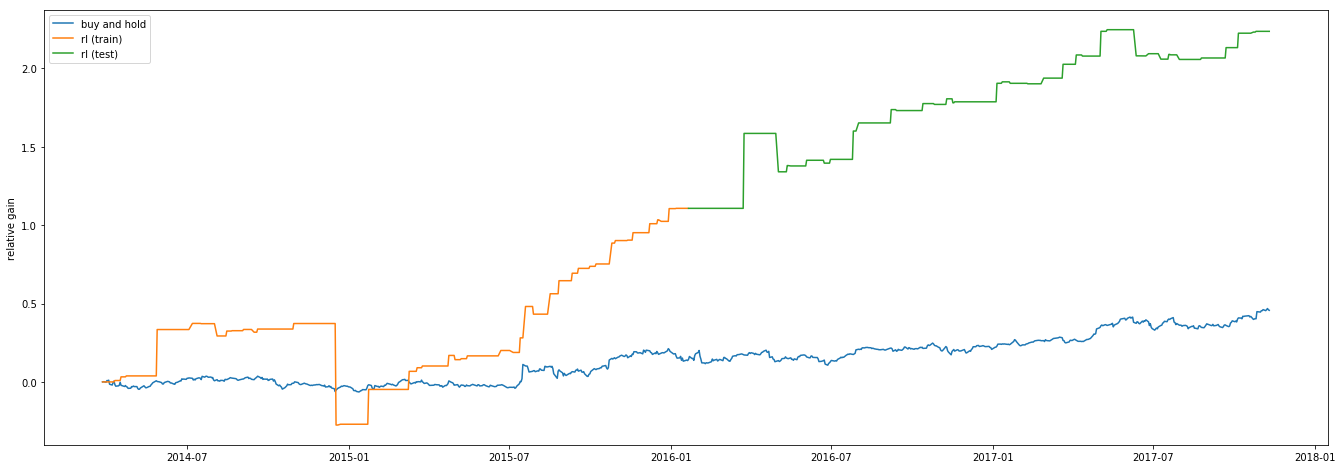

In [14]:
plt.figure(figsize=(23,8))
plt.plot(data.index,((data['Close']-data['Close'][0])/data['Close'][-1]), label='buy and hold')
plt.plot(train.index, ([0] + train_profits)/data['Close'][-1], label='rl (train)')
plt.plot(test.index, (([0] + test_profits) + train_profits[-1])/data['Close'][-1], label='rl (test)')
plt.ylabel('relative gain')
plt.legend()
plt.show()

In [15]:
# Double DQN

def train_ddqn(env, epoch_num=50):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done, profit = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        """ <<< DQN -> Double DQN
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        === """
                        indices = np.argmax(q.data, axis=1)
                        maxqs = Q_ast(b_obs).data
                        """ >>> """
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            """ <<< DQN -> Double DQN
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                            === """
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])
                            """ >>> """
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards

In [16]:
ddqn, total_losses, total_rewards = train_ddqn(Environment(train), epoch_num=50)

5	0.0999999999999992	2285	-49.6	176.039980546	6.68847131729126
10	0.0999999999999992	4570	-29.4	135.628318909	7.325499534606934
15	0.0999999999999992	6855	-22.2	43.2401921686	6.887491226196289
20	0.0999999999999992	9140	-5.8	29.4721577547	7.005911350250244
25	0.0999999999999992	11425	-4.8	42.1132070135	7.4216694831848145
30	0.0999999999999992	13710	2.2	26.7050723445	7.626861810684204
35	0.0999999999999992	15995	6.4	21.747245682	7.677778244018555
40	0.0999999999999992	18280	6.2	13.9992577806	8.57821536064148
45	0.0999999999999992	20565	4.6	8.24441517219	8.089411497116089
50	0.0999999999999992	22850	5.8	13.8208376238	7.9866766929626465


In [17]:
plot_loss_reward(total_losses, total_rewards)

In [18]:
train_profits, test_profits = plot_train_test_by_q(Environment(train), Environment(test), ddqn, 'Double DQN')

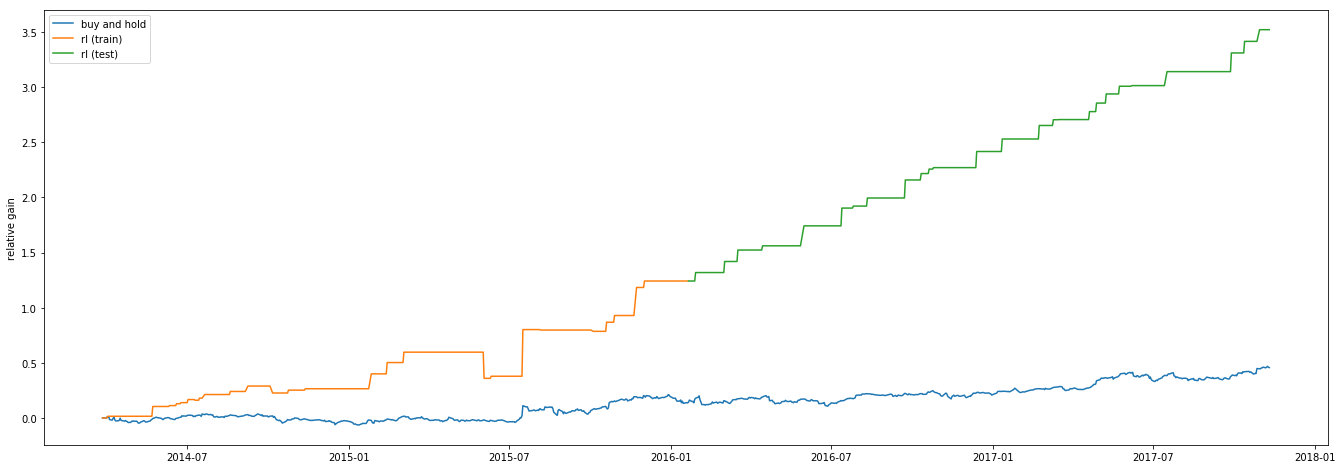

In [19]:
plt.figure(figsize=(23,8))
plt.plot(data.index,((data['Close']-data['Close'][0])/data['Close'][-1]), label='buy and hold')
plt.plot(train.index, ([0] + train_profits)/data['Close'][-1], label='rl (train)')
plt.plot(test.index, (([0] + test_profits) + train_profits[-1])/data['Close'][-1], label='rl (test)')
plt.ylabel('relative gain')
plt.legend()
plt.show()

In [20]:
# Dueling Double DQN

def train_dddqn(env, epoch_num=50):

    """ <<< Double DQN -> Dueling Double DQN
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()
    === """
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size//2),
                fc4 = L.Linear(hidden_size, hidden_size//2),
                state_value = L.Linear(hidden_size//2, 1),
                advantage_value = L.Linear(hidden_size//2, output_size)
            )
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            hs = F.relu(self.fc3(h))
            ha = F.relu(self.fc4(h))
            state_value = self.state_value(hs)
            advantage_value = self.advantage_value(ha)
            advantage_mean = (F.sum(advantage_value, axis=1)/float(self.output_size)).reshape(-1, 1)
            q_value = F.concat([state_value for _ in range(self.output_size)], axis=1) + (advantage_value - F.concat([advantage_mean for _ in range(self.output_size)], axis=1))
            return q_value

        def reset(self):
            self.zerograds()
    """ >>> """

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done, profit = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        """ <<< DQN -> Double DQN
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        === """
                        indices = np.argmax(q.data, axis=1)
                        maxqs = Q_ast(b_obs).data
                        """ >>> """
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            """ <<< DQN -> Double DQN
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                            === """
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])
                            """ >>> """
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards

In [21]:
dddqn, total_losses, total_rewards = train_dddqn(Environment(train), epoch_num=25)

5	0.0999999999999992	2285	-26.6	199.291288683	11.161587715148926
10	0.0999999999999992	4570	-0.2	64.4885835864	18.12753701210022
15	0.0999999999999992	6855	3.0	30.1784009188	12.54375958442688
20	0.0999999999999992	9140	11.0	21.7281668082	12.942126274108887
25	0.0999999999999992	11425	7.6	10.2234404787	12.622957468032837


In [22]:
plot_loss_reward(total_losses, total_rewards)

In [23]:
train_profits, test_profits = plot_train_test_by_q(Environment(train), Environment(test), dddqn, 'Dueling Double DQN')

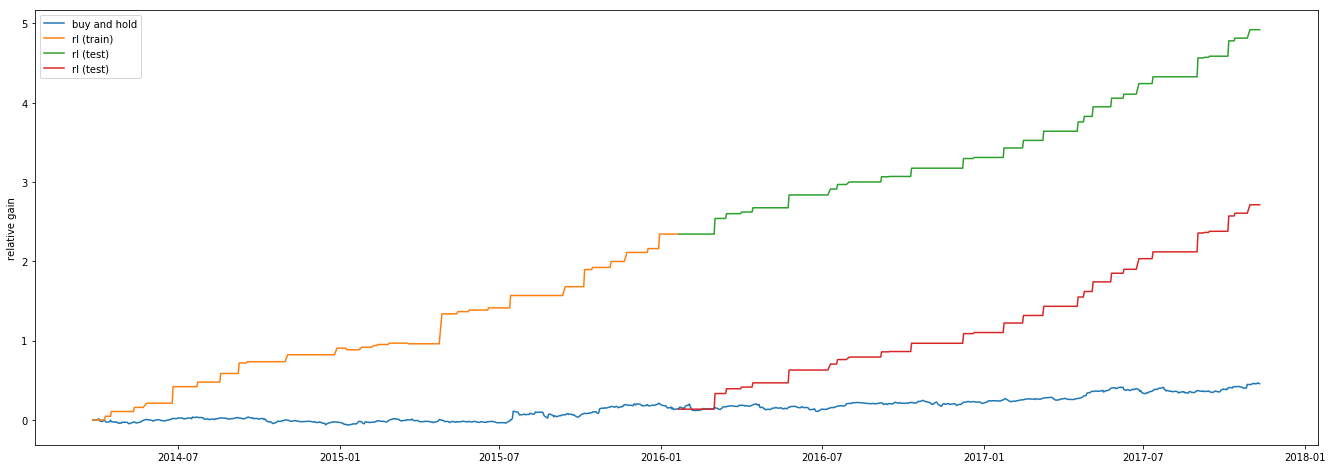

In [24]:
plt.figure(figsize=(23,8))
plt.plot(data.index,((data['Close']-data['Close'][0])/data['Close'][-1]), label='buy and hold')
plt.plot(train.index, ([0] + train_profits)/data['Close'][-1], label='rl (train)')
plt.plot(test.index, (([0] + test_profits) + train_profits[-1])/data['Close'][-1], label='rl (test)')
plt.plot(test.index, (([0] + test_profits) - data['Close'][0] + data['Close'][len(train_profits)])/data['Close'][-1], label='rl (test)')
plt.ylabel('relative gain')
plt.legend()
plt.show()

**Relative Signal Strength**

RSI is used to indicate the trend momentum
The upper region is called overbought and the lower region is oversold
Once the RSI reaches the overbought or oversold region it means the trend is strongly going down or up respectively, but once it exits the region then a trend reversal might occur.

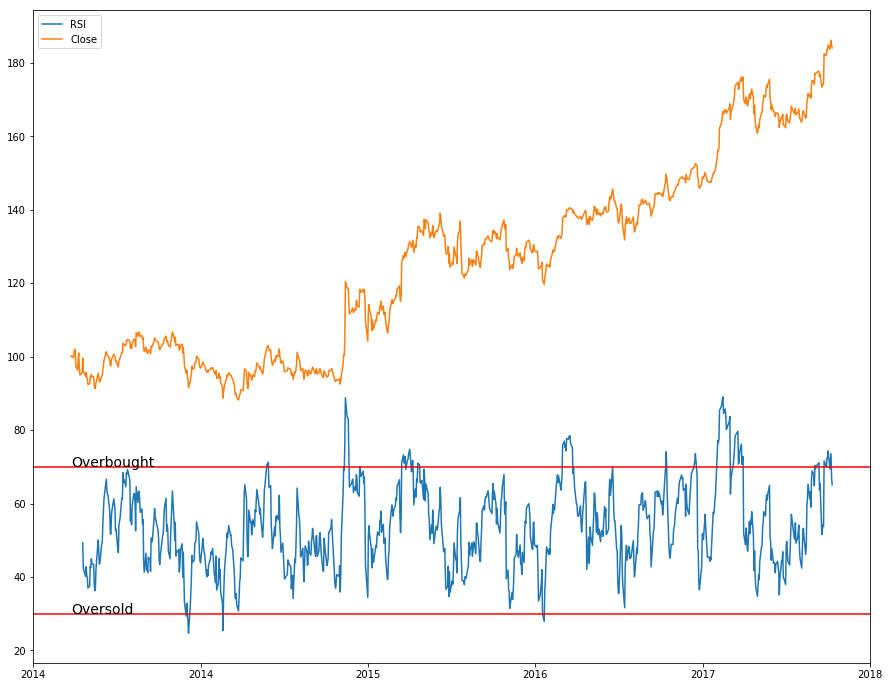

In [25]:
def calcRsi(series, period):
    """
    Calculate the RSI of a data series 
    
    Parameters
    ----------
    series : pandas series
        Candle sticks dataset
    period : int
        Period of each calculation
        
    Returns
    -------
    rsi : float
        the calculated rsi
    """
    try:
        delta = series.diff().dropna()
        u = delta * 0
        d = u.copy()
        u[delta > 0] = delta[delta > 0]
        d[delta < 0] = -delta[delta < 0]
        u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
        u = u.drop(u.index[:(period-1)])
        d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
        d = d.drop(d.index[:(period-1)])

        rs = u.ewm(com=period-1, adjust=False).mean() \
            / d.ewm(com=period-1, adjust=False).mean()
        
        rsi = 100 - 100 / (1 + rs)
    except IndexError:
        rsi = 0
        
    return rsi

column_value='Close'
column_index='Date'

data['RSI'] = calcRsi(data[column_value], 14)

#RSI
fig, ax = plt.subplots(figsize=(15,12))
ax.plot(data.index, data['RSI'])
ax.plot(data.index, data[column_value]/data[column_value][0]*100.0)
ax.axhline(y=70,color='r')
ax.axhline(y=30,color='r')
plt.text(s='Overbought', x=data.index[0], y=70, fontsize=14)
plt.text(s='Oversold', x=data.index[0], y=30, fontsize=14)
plt.legend()
#p = plt.setp(ax.xaxis.get_majorticklabels(), rotation=90, fontsize=8)
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.linspace(xmin, xmax, 6))
plt.show()

**Bollinger Bands**

BB is used to indicate possible trend reversals. Once the trendline crosses any of the upper or lower band then it means a reversal may occur

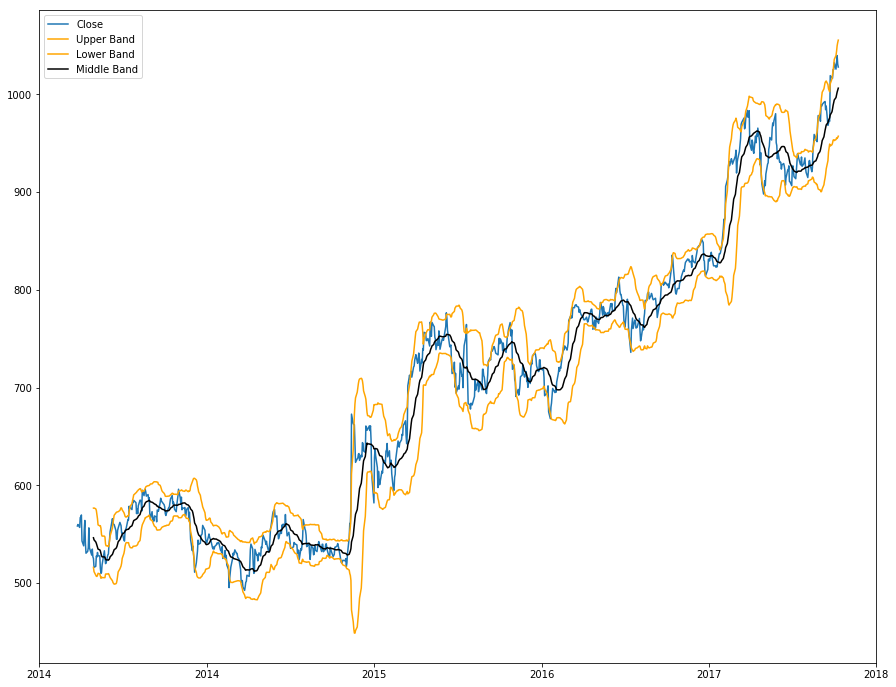

In [26]:
def addBollinger(df, period=20, col='Close'):
    """
    Add the simple moving average column to dataframe 

    Parameters
    ----------
    df : pandas dataframe
        Candle sticks dataset
    period : int
        Period of each calculation

    Returns
    -------
    None
    """
    bbmid_series = df[col].rolling(window=period).mean()
    series_stdev = df[col].rolling(window=period).std()
    df['BBUpperBand'] = bbmid_series + 2*series_stdev
    df['BBLowerBand'] = bbmid_series - 2*series_stdev
    df['BBBandwidth'] = df['BBUpperBand'] - df['BBLowerBand']  
    df['BBMiddleBand'] = bbmid_series
    
    return df


data = addBollinger(data)

column_value='Close'
column_index='Date'

#Bollinger Bands
fig, ax = plt.subplots(figsize=(15,12))
ax.plot(data.index, data[column_value], label='Close')
ax.plot(data.index, data['BBUpperBand'], c='orange', label='Upper Band')
ax.plot(data.index, data['BBLowerBand'], c='orange', label='Lower Band')
ax.plot(data.index, data['BBMiddleBand'], c='black', label='Middle Band')
plt.legend()
#p = plt.setp(ax.xaxis.get_majorticklabels(), rotation=90, fontsize=8)
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.linspace(xmin, xmax, 6))
plt.show()

**Moving Average Convergence Divergence**

MACD is another momentum indicator that helps in telling if the market is losing steam in its current trend and reversal may occur. Trend reversals are usually predicted during crossovers of the signal line and the MACD line

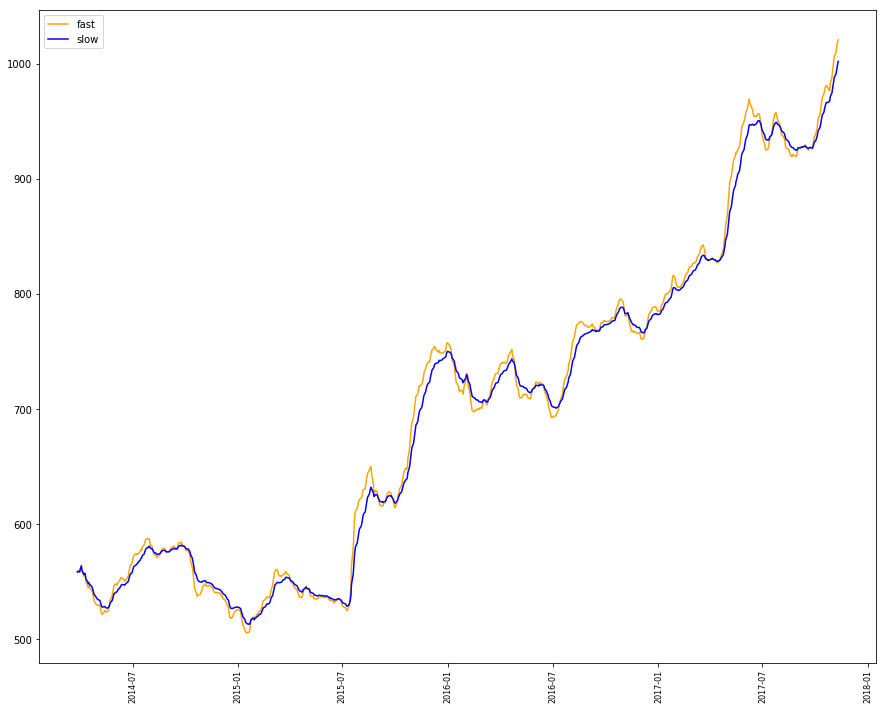

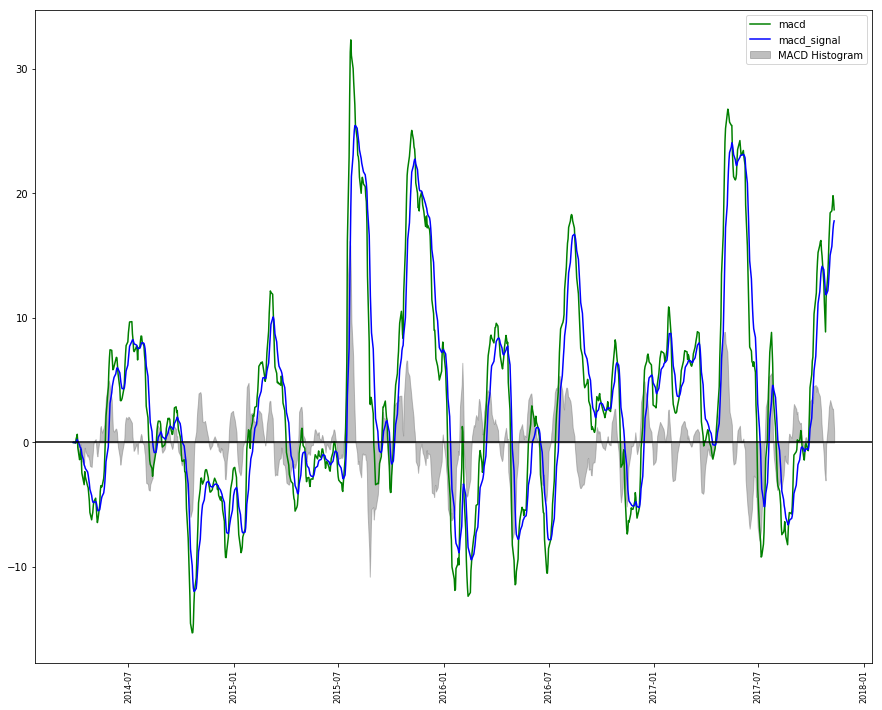

In [27]:
def addMACD(df, column_value='Close'):
    ema_fast = df[column_value].ewm(span=12).mean()
    ema_slow = df[column_value].ewm(span=26).mean()
    signal_line = df[column_value].ewm(span=9).mean()
    df['ema_fast'] = ema_fast
    df['ema_slow'] = ema_slow
    df['macd'] = ema_fast - ema_slow
    df['macd_signal'] = df.macd.ewm(span=9, adjust=False).mean()
    df['macdh'] = df['macd'] - df['macd_signal']
    return df

data = addMACD(data)

fig, ax = plt.subplots(figsize=(15,12))
ax.plot(data.index, data['ema_fast'], c='orange', label='fast')
ax.plot(data.index, data['ema_slow'], c='blue', label='slow')
plt.legend()
p = plt.setp(ax.xaxis.get_majorticklabels(), rotation=90, fontsize=8)
plt.show()

fig, ax = plt.subplots(figsize=(15,12))
ax.plot(data.index, data['macd'], c='green')
# ax.bar(, height=)
ax.plot(data.index, data['macd_signal'], c='blue')
ax.axhline(y=0,color='black')
ax.fill_between(data.index, data['macdh'], color = 'gray', alpha=0.5, label='MACD Histogram')
#ax.set_xticklabels(data.index.reindex(ax.get_xticks()))
plt.legend()
p = plt.setp(ax.xaxis.get_majorticklabels(), rotation=90, fontsize=8)
plt.show()

In [28]:
# Initialize the short and long windows
short_window = 40
long_window = 100

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=data.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = data['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = data['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

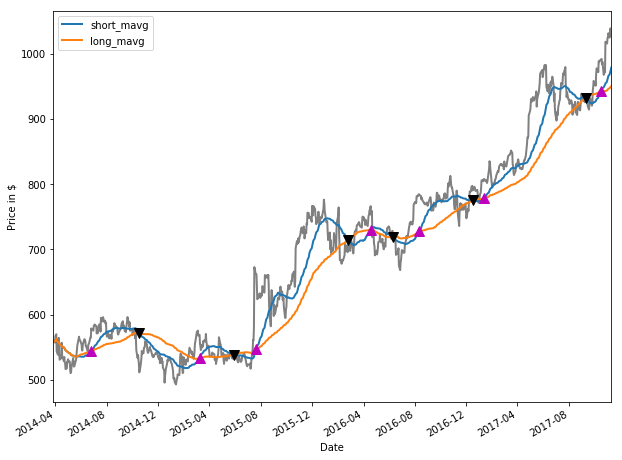

In [29]:
fig = plt.figure(figsize=(10, 8))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
data['Close'].plot(ax=ax1, color='grey', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

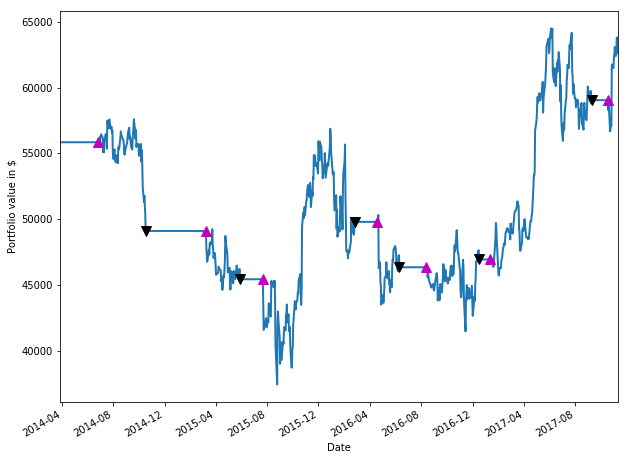

In [30]:
# Set the initial capital
initial_capital= 100*data['Close'][0] #float(0.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['AAPL'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(data['Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(data['Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(data['Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

# Plot the "buy" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')

# Plot the "sell" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

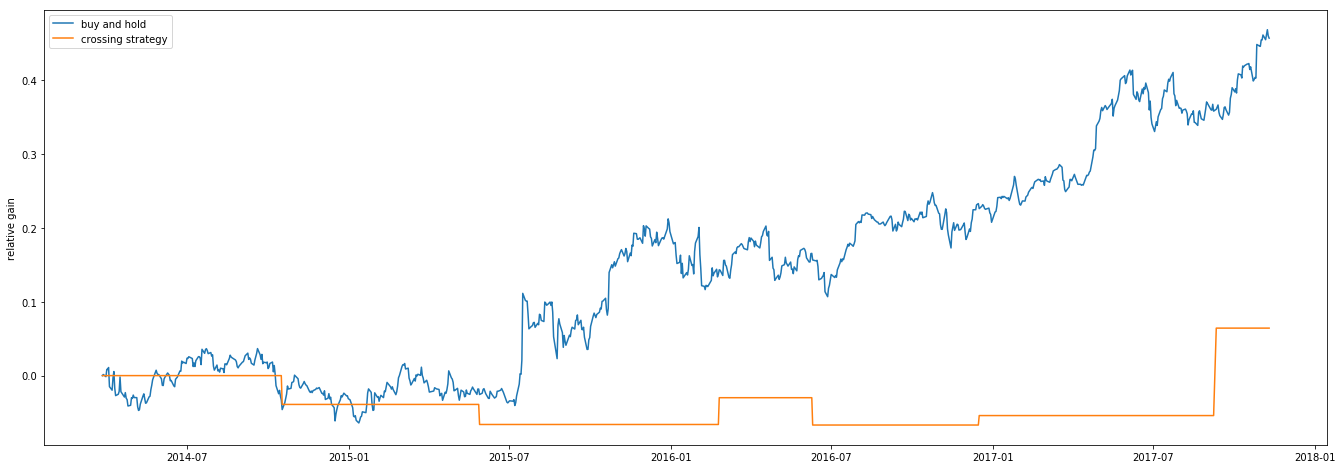

In [31]:
env = Environment(data)
env.reset()
ongoing_profits = []
for i in range(1,len(signals['positions']-1)):
    a = signals['positions'][i]
    if a == -1:
        a = 2
    elif a == float('NaN'):
        a = 0
    obs, reward, done, profit = env.step(a)
    ongoing_profits.append(profit)
    
plt.figure(figsize=(23,8))
plt.plot(data.index,((data['Close']-data['Close'][0])/data['Close'][-1]), label='buy and hold')
plt.plot(data.index, ([0] + ongoing_profits)/data['Close'][-1], label='crossing strategy')
plt.ylabel('relative gain')
plt.legend()
plt.show()